## 1- LOAD DATA
### Target: LOCAL_PRICE_ADJUSTMENT

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
file_path = '../data/processed/PUBLIC_PREDISPATCHIS_202508121400_20250812133340_clean.csv'
df0 = pd.read_csv(file_path, header=0)
df0.head(5)

,DATETIME,DUID,PERIODID,LOCAL_PRICE_ADJUSTMENT,LOCALLY_CONSTRAINED
0,2025/08/13 10:30:00,ARWF1,42.0,-46.53,2.0
1,2025/08/13 11:00:00,ARWF1,43.0,-28.50,2.0
2,2025/08/13 11:30:00,ARWF1,44.0,-23.99,2.0
3,2025/08/13 12:00:00,ARWF1,45.0,-5.98,2.0
4,2025/08/12 14:00:00,BANGOWF1,1.0,-106.44,2.0


## 2- check missing values, data ranges and duplicates

In [3]:
# Check for duplicate rows in the DataFrame
duplicates = df0.duplicated()
print(duplicates.any())  # True if there are any duplicates


False


In [4]:
# Check for missing values in each column
print(df0.isna().sum())

DATETIME                  1
DUID                      1
PERIODID                  1
LOCAL_PRICE_ADJUSTMENT    1
LOCALLY_CONSTRAINED       1
dtype: int64


In [5]:
# To display rows with any missing values
print(df0[df0.isna().any(axis=1)])

     DATETIME DUID  PERIODID  LOCAL_PRICE_ADJUSTMENT  LOCALLY_CONSTRAINED
1979      NaN  NaN       NaN                     NaN                  NaN


In [6]:
df0.dropna(inplace=True)
df0.count()

DATETIME                  1979
DUID                      1979
PERIODID                  1979
LOCAL_PRICE_ADJUSTMENT    1979
LOCALLY_CONSTRAINED       1979
dtype: int64

In [7]:
# Display the range (min and max) for each column in the DataFrame
for col in df0.columns:
    if np.issubdtype(df0[col].dtype, np.number):
        print(f"{col}: min={df0[col].min()}, max={df0[col].max()}")
    else:
        print(f"{col}: unique values count={df0[col].nunique()}")

DATETIME: unique values count=60
DUID: unique values count=93
PERIODID: min=1.0, max=77.0
LOCAL_PRICE_ADJUSTMENT: min=-1116.93, max=1468.97
LOCALLY_CONSTRAINED: min=1.0, max=2.0


## 3- datetime management

In [8]:
# Convert the 'DATETIME' column to proper datetime type
df0['DATETIME'] = pd.to_datetime(df0['DATETIME'])
# sort the DataFrame by 'DATETIME' column
df0.sort_values(by='DATETIME', inplace=True)
df0.reset_index(drop=True, inplace=True)

In [9]:
df0.head(5)

,DATETIME,DUID,PERIODID,LOCAL_PRICE_ADJUSTMENT,LOCALLY_CONSTRAINED
0,2025-08-12 14:00:00,STUBSF1,1.0,-4.99,2.0
1,2025-08-12 14:00:00,WOODLWN1,1.0,4.77,2.0
2,2025-08-12 14:00:00,MCKAY1,1.0,-9.90,2.0
3,2025-08-12 14:00:00,MANSLR1,1.0,-1035.88,2.0
4,2025-08-12 14:00:00,FLYCRKWF,1.0,528.80,2.0


## 4- system-wide analysis or per-DUID 
If we want to do a system-wide prediction, we can group by 'DATETIME' and take the mean of the target variable

In [10]:

df_agg = df0.groupby("DATETIME").agg({
    "LOCAL_PRICE_ADJUSTMENT": "mean",
    "LOCALLY_CONSTRAINED": "mean"
}).reset_index()


In [11]:
df_agg.head(5)

,DATETIME,LOCAL_PRICE_ADJUSTMENT,LOCALLY_CONSTRAINED
0,2025-08-12 14:00:00,-107.038070,1.789474
1,2025-08-12 14:30:00,-8.985714,1.553571
2,2025-08-12 15:00:00,-11.657115,1.596154
3,2025-08-12 15:30:00,-26.312188,1.000000
4,2025-08-12 16:00:00,21.883636,1.939394


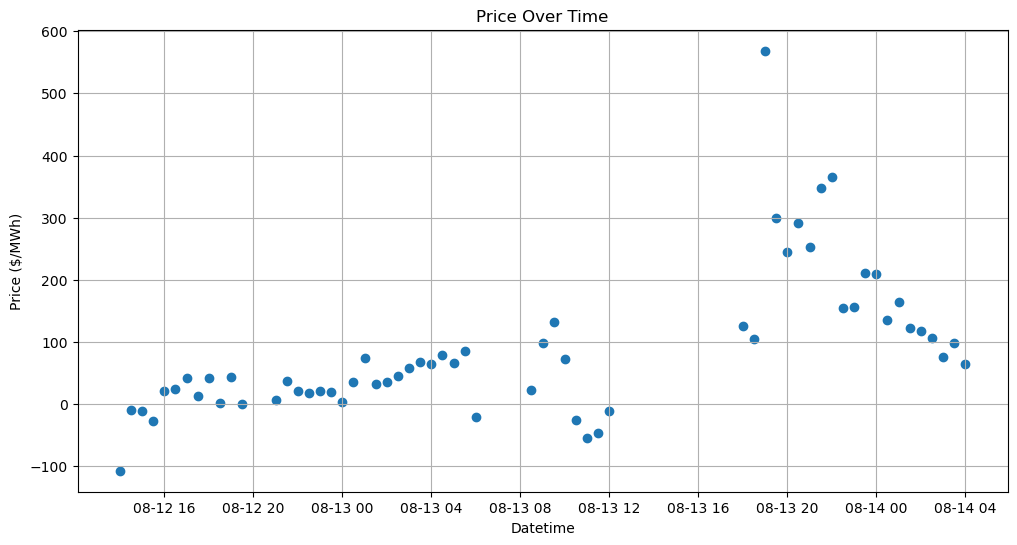

In [12]:
# Plotting the 'LOCAL_PRICE_ADJUSTMENT' over time
plt.figure(figsize=(12,6))
plt.scatter(df_agg['DATETIME'], df_agg['LOCAL_PRICE_ADJUSTMENT'])
plt.title('Price Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price ($/MWh)')
plt.grid(True)
plt.show()


### Functions to create time-based features

In [13]:


# write a function to create date and time features
def create_datetime_features(df):
    #df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df['hour'] = df['DATETIME'].dt.hour
    df['day_of_week'] = df['DATETIME'].dt.dayofweek  # Monday=0
    df['month'] = df['DATETIME'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['is_weekday'] = df['day_of_week'].isin([0,1,2,3,4]).astype(int)
    return df

import holidays
#write a function to add holiday features
def add_holiday_features(df):
    
    # Create a set of Australian holidays for the relevant years in the data
    years = df['DATETIME'].dt.year.unique()
    au_holidays = holidays.country_holidays('AU', years=years)

    # Add is_holiday flag
    df['is_holiday'] = df['DATETIME'].dt.date.isin(au_holidays).astype(int)
    return df

# write a function to create lag features
def create_lag_features(df, lag_hours):
    for lag in lag_hours:
        df[f'lag_{lag}'] = df['LOCAL_PRICE_ADJUSTMENT'].shift(lag)
    return df   

# write a function to create rolling features
def create_rolling_features(df, window_sizes):
    for window in window_sizes:
        df[f'price_roll_mean_{window}'] = df['LOCAL_PRICE_ADJUSTMENT'].rolling(window=window).mean()
        df[f'price_roll_std_{window}'] = df['LOCAL_PRICE_ADJUSTMENT'].rolling(window=window).std()
    return df

## 4- create time-based features

In [14]:
create_datetime_features(df_agg)
create_datetime_features(df0)


,DATETIME,DUID,PERIODID,LOCAL_PRICE_ADJUSTMENT,LOCALLY_CONSTRAINED,hour,day_of_week,month,is_weekend,is_weekday
0,2025-08-12 14:00:00,STUBSF1,1.0,-4.99,2.0,14,1,8,0,1
1,2025-08-12 14:00:00,WOODLWN1,1.0,4.77,2.0,14,1,8,0,1
2,2025-08-12 14:00:00,MCKAY1,1.0,-9.90,2.0,14,1,8,0,1
3,2025-08-12 14:00:00,MANSLR1,1.0,-1035.88,2.0,14,1,8,0,1
4,2025-08-12 14:00:00,FLYCRKWF,1.0,528.80,2.0,14,1,8,0,1
...,...,...,...,...,...,...,...,...,...,...
1974,2025-08-14 04:00:00,COLEASF1,77.0,109.94,2.0,4,3,8,0,1
1975,2025-08-14 04:00:00,LIMOSF21,77.0,109.94,2.0,4,3,8,0,1
1976,2025-08-14 04:00:00,MACKNTSH,77.0,-0.02,1.0,4,3,8,0,1
1977,2025-08-14 04:00:00,WOODLWN1,77.0,34.14,2.0,4,3,8,0,1


In [15]:

df_agg.head(5)

,DATETIME,LOCAL_PRICE_ADJUSTMENT,LOCALLY_CONSTRAINED,hour,day_of_week,month,is_weekend,is_weekday
0,2025-08-12 14:00:00,-107.038070,1.789474,14,1,8,0,1
1,2025-08-12 14:30:00,-8.985714,1.553571,14,1,8,0,1
2,2025-08-12 15:00:00,-11.657115,1.596154,15,1,8,0,1
3,2025-08-12 15:30:00,-26.312188,1.000000,15,1,8,0,1
4,2025-08-12 16:00:00,21.883636,1.939394,16,1,8,0,1


### checking plots

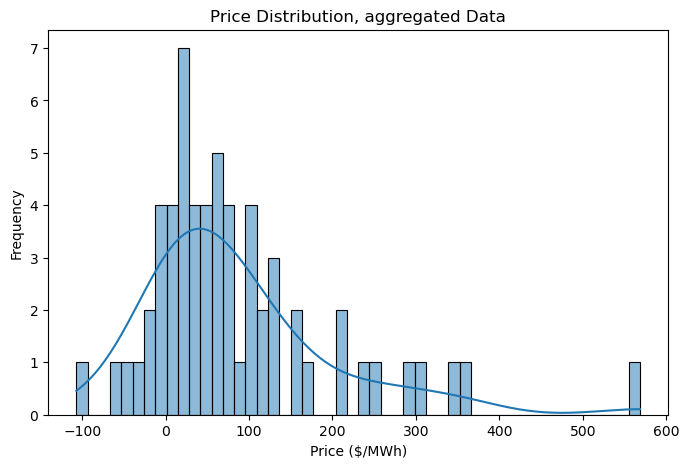

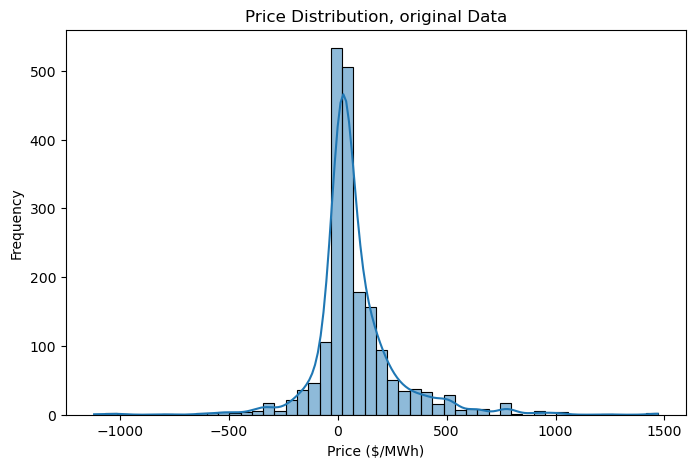

In [16]:
# to check skewness and outliers in the 'LOCAL_PRICE_ADJUSTMENT' column
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df_agg['LOCAL_PRICE_ADJUSTMENT'], bins=50, kde=True,label="df_agg")
plt.title('Price Distribution, aggregated Data')
plt.xlabel('Price ($/MWh)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df0['LOCAL_PRICE_ADJUSTMENT'], bins=50, kde=True,label="df_original")
plt.title('Price Distribution, original Data')
plt.xlabel('Price ($/MWh)')
plt.ylabel('Frequency')
plt.show()


Text(0.5, 1.0, 'Price by Day of Week,original Data')

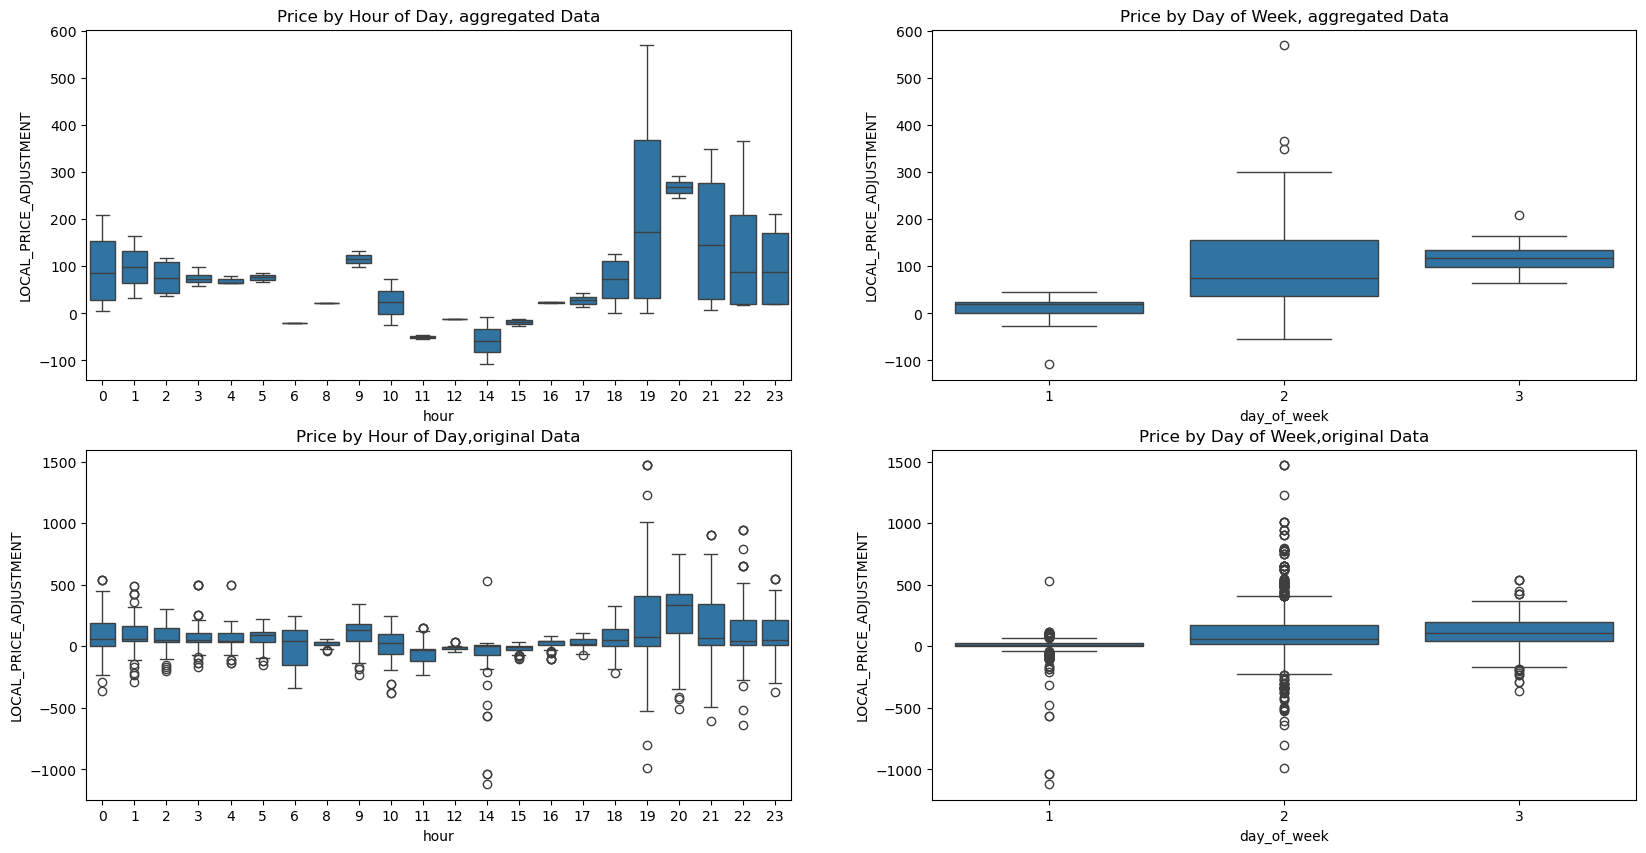

In [17]:
#To see how price varies by hour of day and day of week:
fig, axes = plt.subplots(2, 2, figsize=(20,10))

sns.boxplot(x='hour', y='LOCAL_PRICE_ADJUSTMENT', data=df_agg, ax=axes[0,0])
axes[0,0].set_title('Price by Hour of Day, aggregated Data')


sns.boxplot(x='day_of_week', y='LOCAL_PRICE_ADJUSTMENT', data=df_agg, ax=axes[0,1]) #,
axes[0,1].set_title('Price by Day of Week, aggregated Data')


sns.boxplot(x='hour', y='LOCAL_PRICE_ADJUSTMENT', data=df0, ax=axes[1,0])
axes[1,0].set_title('Price by Hour of Day,original Data')

sns.boxplot(x='day_of_week', y='LOCAL_PRICE_ADJUSTMENT', data=df0, ax=axes[1,1]) #,
axes[1,1].set_title('Price by Day of Week,original Data')



## 4- add lag features
Prices are heavily autocorrelated — we can add previous price values as predictors.

In [18]:
create_lag_features(df_agg, lag_hours=[1, 2, 3, 4, 5, 6, 12, 24])
create_lag_features(df0, lag_hours=[1, 2, 3, 4, 5, 6, 12, 24])

,DATETIME,DUID,PERIODID,LOCAL_PRICE_ADJUSTMENT,LOCALLY_CONSTRAINED,hour,day_of_week,month,is_weekend,is_weekday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_12,lag_24
0,2025-08-12 14:00:00,STUBSF1,1.0,-4.99,2.0,14,1,8,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-08-12 14:00:00,WOODLWN1,1.0,4.77,2.0,14,1,8,0,1,-4.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-08-12 14:00:00,MCKAY1,1.0,-9.90,2.0,14,1,8,0,1,4.77,-4.99,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-08-12 14:00:00,MANSLR1,1.0,-1035.88,2.0,14,1,8,0,1,-9.90,4.77,-4.99,NaN,NaN,NaN,NaN,NaN
4,2025-08-12 14:00:00,FLYCRKWF,1.0,528.80,2.0,14,1,8,0,1,-1035.88,-9.90,4.77,-4.99,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974,2025-08-14 04:00:00,COLEASF1,77.0,109.94,2.0,4,3,8,0,1,109.94,206.87,206.87,109.94,-139.74,109.94,-70.88,34.14
1975,2025-08-14 04:00:00,LIMOSF21,77.0,109.94,2.0,4,3,8,0,1,109.94,109.94,206.87,206.87,109.94,-139.74,142.06,34.14
1976,2025-08-14 04:00:00,MACKNTSH,77.0,-0.02,1.0,4,3,8,0,1,109.94,109.94,109.94,206.87,206.87,109.94,34.14,-0.02
1977,2025-08-14 04:00:00,WOODLWN1,77.0,34.14,2.0,4,3,8,0,1,-0.02,109.94,109.94,109.94,206.87,206.87,34.14,173.02


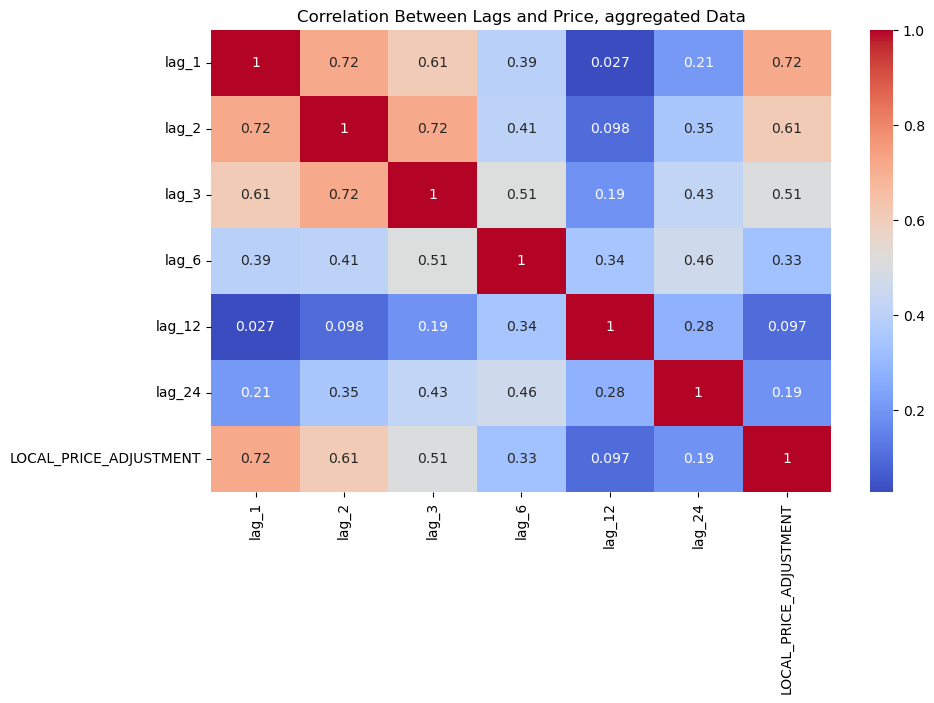

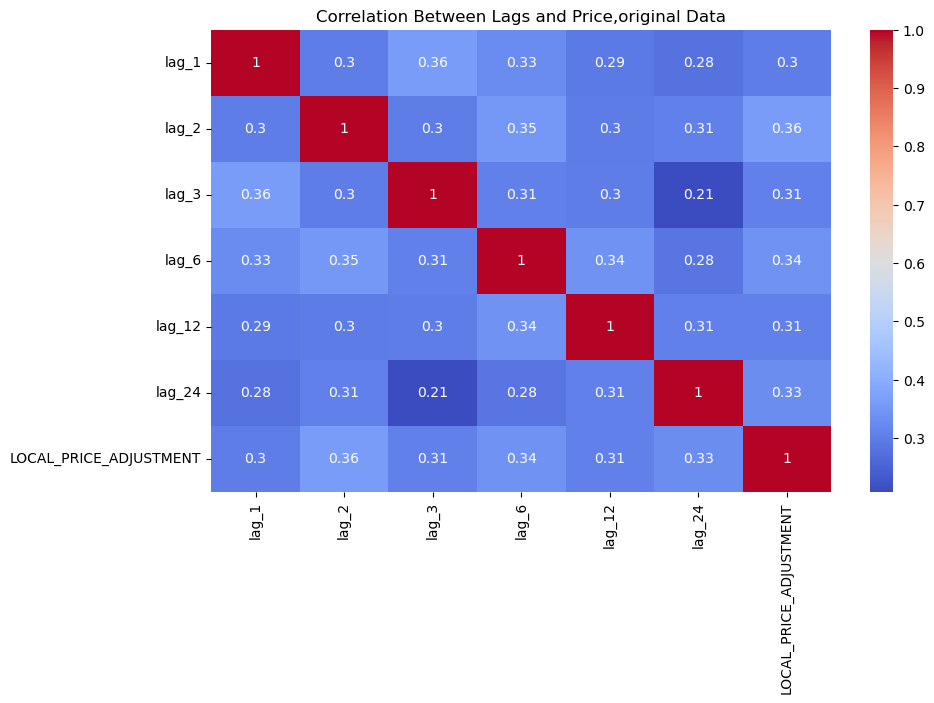

In [19]:

plt.figure(figsize=(10,6))
sns.heatmap(df_agg[[f'lag_{l}' for l in [1,2,3,6,12,24]] + ['LOCAL_PRICE_ADJUSTMENT']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Lags and Price, aggregated Data')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df0[[f'lag_{l}' for l in [1,2,3,6,12,24]] + ['LOCAL_PRICE_ADJUSTMENT']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Lags and Price,original Data')
plt.show()


In [20]:
# lag_12 has the lowest correlation with the target variable
# So we can remove lag_12
# lags_to_remove = ['lag_12']
# df.drop(columns=lags_to_remove, inplace=True)

## 5- Rolling window stats
Smooth past data into trends & volatility measures.


In [21]:
create_rolling_features(df_agg, window_sizes=[3, 6, 12, 24])
create_rolling_features(df0, window_sizes=[3, 6, 12, 24])   

,DATETIME,DUID,PERIODID,LOCAL_PRICE_ADJUSTMENT,LOCALLY_CONSTRAINED,hour,day_of_week,month,is_weekend,is_weekday,...,lag_12,lag_24,price_roll_mean_3,price_roll_std_3,price_roll_mean_6,price_roll_std_6,price_roll_mean_12,price_roll_std_12,price_roll_mean_24,price_roll_std_24
0,2025-08-12 14:00:00,STUBSF1,1.0,-4.99,2.0,14,1,8,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-08-12 14:00:00,WOODLWN1,1.0,4.77,2.0,14,1,8,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-08-12 14:00:00,MCKAY1,1.0,-9.90,2.0,14,1,8,0,1,...,NaN,NaN,-3.373333,7.467425,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-08-12 14:00:00,MANSLR1,1.0,-1035.88,2.0,14,1,8,0,1,...,NaN,NaN,-347.003333,596.629784,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-08-12 14:00:00,FLYCRKWF,1.0,528.80,2.0,14,1,8,0,1,...,NaN,NaN,-172.326667,794.885333,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974,2025-08-14 04:00:00,COLEASF1,77.0,109.94,2.0,4,3,8,0,1,...,-70.88,34.14,142.250000,55.962562,100.636667,126.973730,100.685000,92.780021,76.765000,88.706086
1975,2025-08-14 04:00:00,LIMOSF21,77.0,109.94,2.0,4,3,8,0,1,...,142.06,34.14,109.940000,0.000000,142.250000,50.054437,98.008333,91.937353,79.923333,88.471560
1976,2025-08-14 04:00:00,MACKNTSH,77.0,-0.02,1.0,4,3,8,0,1,...,34.14,-0.02,73.286667,63.485436,123.923333,77.082877,95.161667,94.585408,79.923333,88.471560
1977,2025-08-14 04:00:00,WOODLWN1,77.0,34.14,2.0,4,3,8,0,1,...,34.14,173.02,48.020000,56.278692,95.135000,71.996025,95.161667,94.585408,74.136667,86.640552


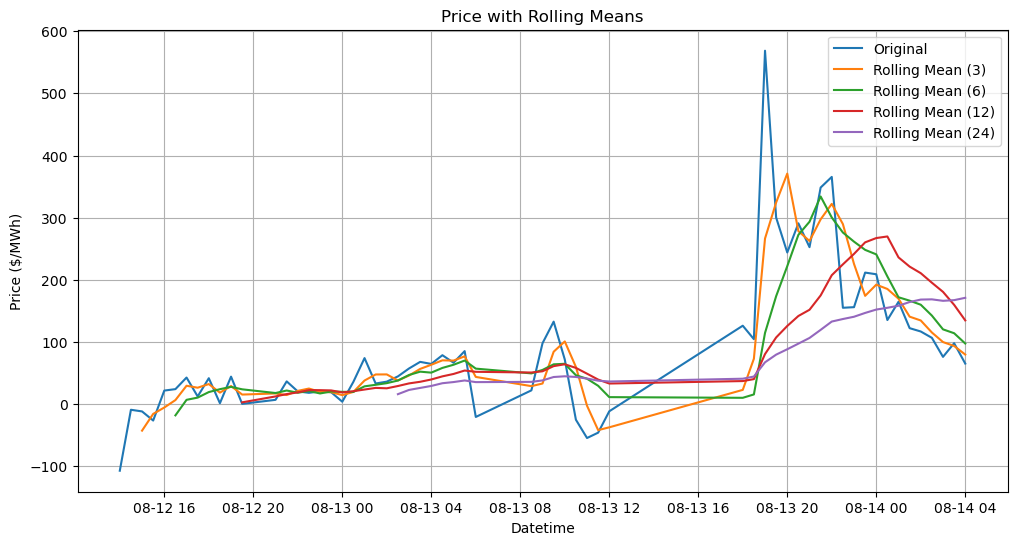

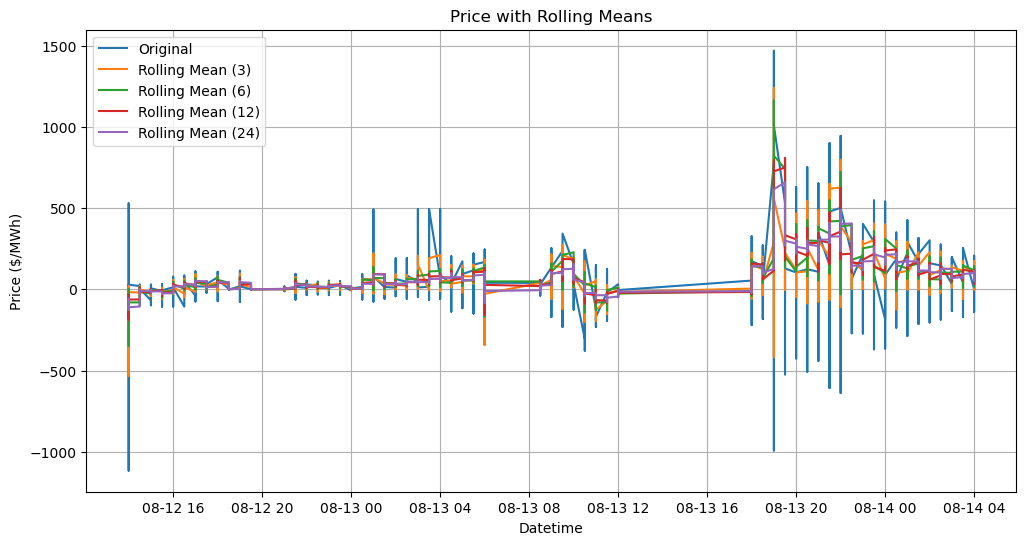

In [22]:
def plot_rolling_means(df):
    plt.figure(figsize=(12,6))
    plt.plot(df['DATETIME'], df['LOCAL_PRICE_ADJUSTMENT'], label='Original')
    plt.plot(df['DATETIME'], df['price_roll_mean_3'], label='Rolling Mean (3)')
    plt.plot(df['DATETIME'], df['price_roll_mean_6'], label='Rolling Mean (6)')
    plt.plot(df['DATETIME'], df['price_roll_mean_12'], label='Rolling Mean (12)')
    plt.plot(df['DATETIME'], df['price_roll_mean_24'], label='Rolling Mean (24)')
    plt.legend()
    plt.title('Price with Rolling Means')
    plt.xlabel('Datetime')
    plt.ylabel('Price ($/MWh)')
    plt.grid(True)
    plt.show()

plot_rolling_means(df_agg)
plot_rolling_means(df0)

In [23]:
#show all of the rows with NaN values 
nan_rows = df0[df0.isna().any(axis=1)]
print(nan_rows.count())
print(nan_rows[:1]) 

DATETIME                  24
DUID                      24
PERIODID                  24
LOCAL_PRICE_ADJUSTMENT    24
LOCALLY_CONSTRAINED       24
hour                      24
day_of_week               24
month                     24
is_weekend                24
is_weekday                24
lag_1                     23
lag_2                     22
lag_3                     21
lag_4                     20
lag_5                     19
lag_6                     18
lag_12                    12
lag_24                     0
price_roll_mean_3         22
price_roll_std_3          22
price_roll_mean_6         19
price_roll_std_6          19
price_roll_mean_12        13
price_roll_std_12         13
price_roll_mean_24         1
price_roll_std_24          1
dtype: int64
             DATETIME     DUID  PERIODID  LOCAL_PRICE_ADJUSTMENT  \
0 2025-08-12 14:00:00  STUBSF1       1.0                   -4.99   

   LOCALLY_CONSTRAINED  hour  day_of_week  month  is_weekend  is_weekday  ...  \
0              

In [24]:
#show all of the rows with NaN values 
nan_rows = df_agg[df_agg.isna().any(axis=1)]
print(nan_rows.count())
print(nan_rows[:1]) 

DATETIME                  24
LOCAL_PRICE_ADJUSTMENT    24
LOCALLY_CONSTRAINED       24
hour                      24
day_of_week               24
month                     24
is_weekend                24
is_weekday                24
lag_1                     23
lag_2                     22
lag_3                     21
lag_4                     20
lag_5                     19
lag_6                     18
lag_12                    12
lag_24                     0
price_roll_mean_3         22
price_roll_std_3          22
price_roll_mean_6         19
price_roll_std_6          19
price_roll_mean_12        13
price_roll_std_12         13
price_roll_mean_24         1
price_roll_std_24          1
dtype: int64
             DATETIME  LOCAL_PRICE_ADJUSTMENT  LOCALLY_CONSTRAINED  hour  \
0 2025-08-12 14:00:00              -107.03807             1.789474    14   

   day_of_week  month  is_weekend  is_weekday  lag_1  lag_2  ...  lag_12  \
0            1      8           0           1    NaN    NaN  .

In [25]:
# By keeping roll_24 we lose all of 12 August data
# So we can remove roll_24
# rolls_to_remove = ['price_roll_mean_24', 'price_roll_std_24']
# df.drop(columns=rolls_to_remove, inplace=True)

In [26]:
df_agg.describe()

,DATETIME,LOCAL_PRICE_ADJUSTMENT,LOCALLY_CONSTRAINED,hour,day_of_week,month,is_weekend,is_weekday,lag_1,lag_2,...,lag_12,lag_24,price_roll_mean_3,price_roll_std_3,price_roll_mean_6,price_roll_std_6,price_roll_mean_12,price_roll_std_12,price_roll_mean_24,price_roll_std_24
count,60,60.000000,60.000000,60.000000,60.000000,60.0,60.0,60.0,59.000000,58.000000,...,48.000000,36.000000,58.000000,58.000000,55.000000,55.000000,49.000000,49.000000,37.000000,37.000000
mean,2025-08-13 08:26:30.000000256,86.557071,1.955128,11.800000,1.850000,8.0,0.0,1.0,86.917102,86.724610,...,74.502318,30.184614,89.509325,41.321213,92.484138,54.237041,94.909765,70.409144,87.369415,90.138262
min,2025-08-12 14:00:00,-107.038070,1.000000,0.000000,1.000000,8.0,0.0,1.0,-107.038070,-107.038070,...,-107.038070,-107.038070,-42.560300,1.137978,-17.983191,9.493766,2.961039,15.183432,16.086353,22.830406
25%,2025-08-12 22:22:30,18.985000,2.000000,3.000000,1.000000,8.0,0.0,1.0,18.749032,18.513065,...,6.230968,6.230968,20.182688,14.928499,21.591425,19.295991,29.211667,22.458683,37.800111,34.319103
50%,2025-08-13 05:45:00,61.108710,2.000000,13.000000,2.000000,8.0,0.0,1.0,57.440968,51.070000,...,36.466129,28.723377,47.839355,23.802740,50.742419,31.238875,52.078188,45.857468,67.358175,118.266023
75%,2025-08-13 20:37:30,123.267258,2.000000,19.000000,2.000000,8.0,0.0,1.0,124.252903,125.238548,...,80.424516,59.274839,129.808978,52.035167,151.244785,73.678754,159.798306,91.233152,146.774197,144.313251
max,2025-08-14 04:00:00,568.566452,2.000000,23.000000,3.000000,8.0,0.0,1.0,568.566452,568.566452,...,568.566452,132.763548,370.919570,261.858386,334.123441,235.161624,269.789113,192.676507,171.115757,154.429868
std,NaN,116.323393,0.155875,8.167318,0.659353,0.0,0.0,0.0,117.288174,118.303143,...,125.427207,42.939223,103.026512,50.889939,94.623399,53.787999,83.977984,59.358001,56.338810,56.487449


In [27]:
df0.describe()

,DATETIME,PERIODID,LOCAL_PRICE_ADJUSTMENT,LOCALLY_CONSTRAINED,hour,day_of_week,month,is_weekend,is_weekday,lag_1,...,lag_12,lag_24,price_roll_mean_3,price_roll_std_3,price_roll_mean_6,price_roll_std_6,price_roll_mean_12,price_roll_std_12,price_roll_mean_24,price_roll_std_24
count,1979,1979.000000,1979.000000,1979.000000,1979.000000,1979.000000,1979.0,1979.0,1979.0,1978.000000,...,1967.000000,1955.000000,1977.000000,1977.000000,1974.000000,1974.000000,1968.000000,1968.000000,1956.000000,1956.000000
mean,2025-08-13 07:49:04.214249472,36.635675,79.564578,1.941385,11.811016,1.823648,8.0,0.0,1.0,79.549221,...,79.485755,79.592440,79.603118,98.555016,79.813603,107.740946,80.263647,113.545552,80.850472,118.226407
min,2025-08-12 14:00:00,1.000000,-1116.930000,1.000000,0.000000,1.000000,8.0,0.0,1.0,-1116.930000,...,-1116.930000,-1116.930000,-531.760000,0.000000,-348.623333,0.208207,-185.845000,0.410287,-127.852083,0.478827
25%,2025-08-12 21:30:00,16.000000,4.770000,2.000000,3.000000,1.000000,8.0,0.0,1.0,4.770000,...,4.405000,4.770000,4.410000,18.486756,7.003333,27.495309,11.375208,33.525411,13.506146,38.413123
50%,2025-08-13 05:30:00,32.000000,41.430000,2.000000,14.000000,2.000000,8.0,0.0,1.0,41.430000,...,41.430000,41.430000,38.786667,53.612746,44.507500,66.825594,46.960833,80.016401,46.606667,96.138087
75%,2025-08-13 20:30:00,62.000000,127.990000,2.000000,19.000000,2.000000,8.0,0.0,1.0,127.990000,...,127.990000,127.990000,117.220000,127.730740,118.691250,152.163581,118.880833,150.651364,123.332500,149.937955
max,2025-08-14 04:00:00,77.000000,1468.970000,2.000000,23.000000,3.000000,8.0,0.0,1.0,1468.970000,...,1468.970000,1468.970000,1239.550000,1310.712128,1162.848333,852.279478,808.844167,679.615575,659.085417,594.205410
std,NaN,24.518872,196.049642,0.234963,7.903018,0.659171,0.0,0.0,0.0,196.098028,...,196.519804,197.026417,144.945556,128.349887,129.662765,119.020616,120.045572,112.365444,113.603707,108.529586


## 6- Encode categorical variables
DUID is categorical (generator ID). If we want to proceed with system-wide forecasting, we continue with the aggregated data (over DUIDs). However, if we need forecasting per DUID, we need to do one-hot encoding:


In [34]:
df0 = pd.get_dummies(df0, columns=['DUID'], drop_first=True)


In [35]:

# drop Nan rows
df0.dropna(inplace=True)
df_agg.dropna(inplace=True)

In [36]:
import os
def save_features(df, file_name):
    """
    Save the features DataFrame to a CSV file.
    """
    os.makedirs('../data/features', exist_ok=True)
    df.to_csv('../data/features/%s.csv'%file_name, index=False)


save_features(df_agg, 'features_agg')
save_features(df0, 'features_original')


In [31]:
from graphviz import Digraph

# Create a directed graph
dot = Digraph(comment="Data Flow for Price Forecasting Project")

# Nodes
dot.node("A", "Raw AEMO Data (CSV)")
dot.node("B", "01_Preprocess.ipynb\n(cleaning, formatting)")
dot.node("C", "Cleaned CSV\n(data/processed/)")
dot.node("D", "02_Feature_Engineering.ipynb\n(lags, rolling stats, time features)")
dot.node("E", "Feature CSV\n(data/features/)")
dot.node("F", "03_Model_Training.ipynb\n(train ML model)")
dot.node("G", "Price Forecast Model")

# Edges
dot.edges([("A", "B"), ("B", "C"), ("C", "D"), ("D", "E"), ("E", "F"), ("F", "G")])

# Render to file
output_path = '../data/data_flow_forecasting'
dot.format = 'png'
dot.render(output_path, cleanup=True)

output_path + '.png'


'../data/data_flow_forecasting.png'